In [1]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.manifold import spectral_embedding
from scipy.optimize import linear_sum_assignment as linear_assignment
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# load the data
all_data = pd.read_csv('mnist_test.csv', header=None)
selected_data = all_data[all_data.iloc[:,0].isin([2, 7])] # label included
X = selected_data.iloc[:, 1:] # [n_samples, n_features]
labels = selected_data.iloc[:, 0].replace(2, 0).replace(7, 1).tolist() # change label 2 to 0, change label 7 to 1
n_samples = X.shape[0]

In [3]:
# compute the weighted matrix
def compute_weighted_matrix(data, sigma):
    init_mat = pairwise_distances(data, metric="euclidean")
    weighted_mat = np.exp(-init_mat**2/(2*sigma**2))
    return weighted_mat

# compute the cost matrix for later use of linear assignment
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

When sigma = 2000, the accuracy is: 0.949


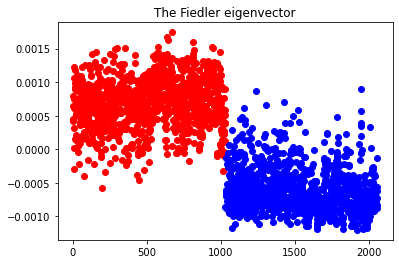

When sigma = 1000, the accuracy is: 0.945


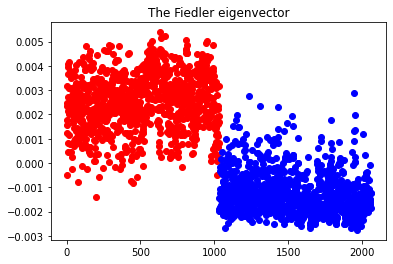

When sigma = 5000, the accuracy is: 0.949


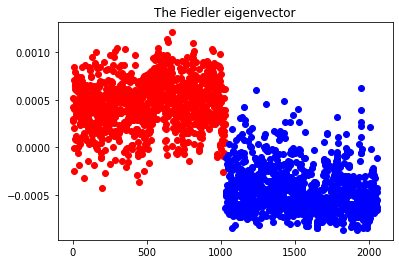

In [4]:
sigma_lst = [2000, 1000, 5000] # It's better to choose the median of pairwise distance

# spectral clustering
for sigma in sigma_lst:
    W = compute_weighted_matrix(X, sigma)
    clustering = SpectralClustering(n_clusters=2, affinity='precomputed')
    pred_labels = clustering.fit_predict(W)
    
    cm = confusion_matrix(labels, pred_labels)
    indexes = linear_assignment(_make_cost_m(cm))
    indexes = np.asarray(indexes)
    indexes = np.transpose(indexes)
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    
    # compute accuracy
    print('When sigma = {}, the accuracy is: {}'
          .format(sigma, round(np.trace(cm2) / np.sum(cm2), 3)))
    
    # plot the Fiedler eigenvector:
    eigenmap = spectral_embedding(W, n_components=1, drop_first=True)
    Fiedler_vec = np.squeeze(eigenmap)
    twos = [Fiedler_vec[i] for i in range(n_samples) if labels[i] == 0]
    sevens = [Fiedler_vec[i] for i in range(n_samples) if labels[i] == 1]
    plt.figure()
    plt.scatter(np.arange(len(twos)), twos, c='red')
    plt.scatter(np.arange(len(twos), n_samples), sevens, c='blue')
    plt.title('The Fiedler eigenvector')
    plt.show()

In [5]:
# The plots above show that the data is well-seperated.